In [1]:
import os
os.chdir("../..")

In [2]:
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
import pickle
import numpy as np
import pandas as pd
import copy
from q_probe.data import load_all_samples

/n/holylfs05/LABS/pfister_lab/Lab/coxfs01/pfister_lab2/Lab/like/anaconda3/envs/q-probe/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def estimator(n: int, c: int, k: int) -> float:
    """Calculates 1 - comb(n - c, k) / comb(n, k)."""
    if n - c < k:
        return 1.0
    return 1.0 - np.prod(1.0 - k / np.arange(n - c + 1, n + 1))

def pass_at_k(samples, chunk_size):
    sample_dict = {}
    for sample in samples:
        if sample["idx"] not in sample_dict:
            sample_dict[sample["idx"]] = [sample]
        else:
            sample_dict[sample["idx"]].append(sample)
    
    estimates = []
    for idx in sample_dict.keys():
        c = sum([s["reward"] for s in sample_dict[idx]])
        n = len(sample_dict[idx])
        estimates.append(estimator(n, c, chunk_size))
    return sum(estimates) / len(estimates)

# Compute values for tables

In [4]:
api_name = "llama70B_samples_api"
openai_paths = dict(
mbpp_train =  f"./{api_name}/base_train/samples/local_kl",
mbpp_test = f"./{api_name}/base/samples/local_kl",
humaneval_test = f"./{api_name}/base_he/samples/local_kl",
greedy_mbpp_train =  f"./{api_name}/base_train_greedy/samples/local_kl",
greedy_mbpp_test = f"./{api_name}/base_greedy/samples/local_kl",
greedy_humaneval_test = f"./{api_name}/base_he_greedy/samples/local_kl",
)

llama_paths = dict(
mbpp_train =  "./samples/14765178",
mbpp_test = "./samples/13643197",
humaneval_test = "./samples/17018932",
greedy_mbpp_train =  "./samples/12144658",
greedy_mbpp_test =  "./samples/12135933",
greedy_humaneval_test = "./samples/17039648",
)

In [5]:
def get_skyline(path, k=10):
    samples = load_all_samples(path)
    return pass_at_k(samples, k)

def get_table(paths):

    samples = {}
    for name in paths:
        samples[name] = load_all_samples(paths[name])
    
    table = {}
    for name in samples:
        rewards = [s["reward"] for s in samples[name]]
        table[name] = np.mean(rewards)

    for key in ["mbpp_train", "mbpp_test", "humaneval_test"]:
        table[key + "_skyline"] = get_skyline(paths[key], 10)
    
    return table

In [6]:
openai_table = get_table(openai_paths)
llama_table = get_table(llama_paths)

In [7]:
for name, table in zip(["openai", "llama"], [openai_table, llama_table]):
    for k,v in table.items():
        print(k, f"{v:.4f}")
    print()

mbpp_train 0.7014
mbpp_test 0.6530
humaneval_test 0.5399
greedy_mbpp_train 0.7155
greedy_mbpp_test 0.6540
greedy_humaneval_test 0.5854
mbpp_train_skyline 0.8097
mbpp_test_skyline 0.7687
humaneval_test_skyline 0.7293

mbpp_train 0.3400
mbpp_test 0.2938
humaneval_test 0.2428
greedy_mbpp_train 0.4483
greedy_mbpp_test 0.3760
greedy_humaneval_test 0.3049
mbpp_train_skyline 0.6897
mbpp_test_skyline 0.6228
humaneval_test_skyline 0.5627



In [8]:
get_skyline(openai_paths["mbpp_test"], 48)

0.8017529833579745

In [9]:
get_skyline(openai_paths["humaneval_test"], 48)

0.8123814064003875

In [10]:
get_skyline(llama_paths["mbpp_test"], 48)

0.7561023933749167

In [11]:
get_skyline(llama_paths["humaneval_test"], 48)

0.7709832002317636

# Load data from sweep

In [ ]:
results = []
for seed in range(10):
    for loss in ["pg", "ce", "mse"]:
        for prefix in [f"probs_{api_name}_mbpp", "probs_mbpp"]: 

            filename = f"{prefix}_{loss}_sweep_{seed}.pkl"
            with open(f"../../results/{filename}", "rb") as f:
                pkl_dict = pickle.load(f)
            df_results = pd.DataFrame(pkl_dict)
            
            # Add columns
            if loss == "pg":
                df_results["loss"] =  "$L_{PG}$"
            elif loss == "ce":
                df_results["loss"] = "$L_{CE}$"
            else:
                df_results["loss"] = "$L_Q$"

            if prefix == f"probs_{api_name}_mbpp":
                df_results["model"] = "OpenAI"
            else:
                df_results["model"] = "LLAMA"
            results.append(df_results)
df = pd.concat(results)

In [12]:
df.head()

,n_probs,seed,layer,val_rs,test_rs,he_rs,k,temp,loss,model
0,5,0,1,0.0,0.650920,0.558902,2,0.00,$L_{PG}$,OpenAI
1,5,0,1,0.0,0.652584,0.544079,2,0.01,$L_{PG}$,OpenAI
2,5,0,1,0.0,0.653000,0.540312,2,0.10,$L_{PG}$,OpenAI
3,5,0,1,0.0,0.652986,0.539919,2,1.00,$L_{PG}$,OpenAI
4,5,0,1,0.0,0.645920,0.565610,4,0.00,$L_{PG}$,OpenAI


# Plot layers and data size

210


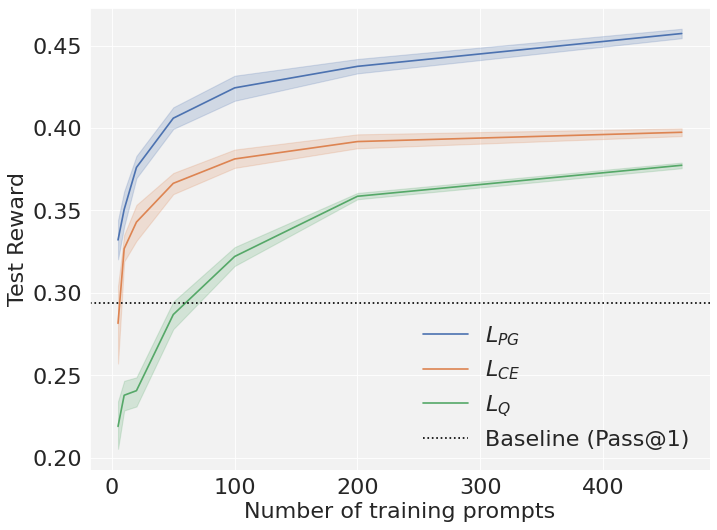

In [22]:
df_plot = copy.deepcopy(df)

# Conditions for the plot
table = llama_table
df_plot = df_plot[df_plot["model"] == "LLAMA"]
df_plot = df_plot[df_plot["k"] == 48]
df_plot = df_plot[df_plot["temp"] == 0.1]
df_plot = df_plot[df_plot["layer"] == 1]

print(len(df_plot))


# Set style
palette = sns.color_palette('deep', n_colors=df_plot['loss'].nunique())
fs = 20
sns.set_style("darkgrid", {"axes.facecolor": ".95"})
fig, ax =plt.subplots(figsize=(10, 7.5), dpi= 80, facecolor='w', edgecolor='k')
plt.rcParams['font.size'] = fs

# Make plot
sns.lineplot(x="n_probs", y="test_rs", hue="loss", data=df_plot, errorbar=('ci', 95), ax=ax, palette=palette)
# ax.axhline(y=table["mbpp_test_skyline"], color='k', linestyle='-.', label="Skyline (Pass@10)")
ax.axhline(y=table["mbpp_test"], color='k', linestyle=':', label="Baseline (Pass@1)")


ax.set_ylabel("Test Reward", fontsize=fs)
ax.set_xlabel("Number of training prompts", fontsize=fs)
ax.legend( loc='lower right', frameon=False,  bbox_to_anchor=(1.0, 0.0))
plt.show()

210


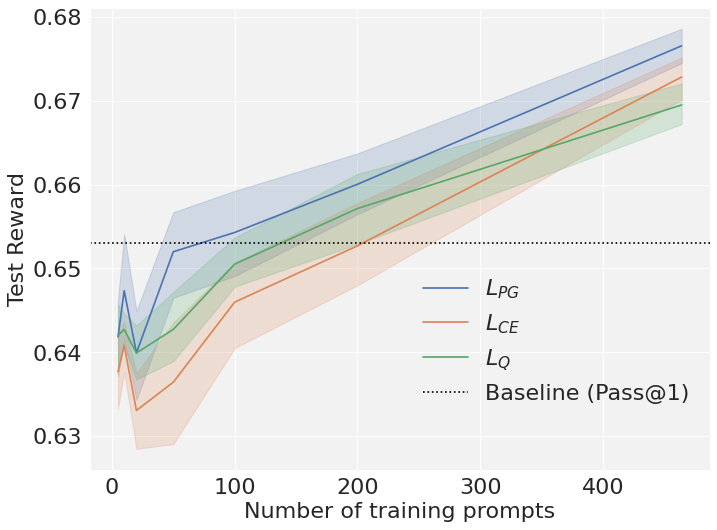

In [14]:
df_plot = copy.deepcopy(df)

# Conditions for the plot
table = openai_table
df_plot = df_plot[df_plot["model"] == "OpenAI"]
df_plot = df_plot[df_plot["k"] == 48]
df_plot = df_plot[df_plot["temp"] == 0.01]
df_plot = df_plot[df_plot["layer"] == 3]

print(len(df_plot))


# Set style
palette = sns.color_palette('deep', n_colors=df_plot['loss'].nunique() )
fs = 20
sns.set_style("darkgrid", {"axes.facecolor": ".95"})
fig, ax =plt.subplots(figsize=(10, 7.5), dpi= 80, facecolor='w', edgecolor='k')
plt.rcParams['font.size'] = fs

# Make plot
sns.lineplot(x="n_probs", y="test_rs", hue="loss", data=df_plot, errorbar=('ci', 95), ax=ax, palette=palette)
ax.axhline(y=table["mbpp_test"], color='k', linestyle=':', label="Baseline (Pass@1)")


ax.set_ylabel("Test Reward", fontsize=fs)
ax.set_xlabel("Number of training prompts", fontsize=fs)
ax.legend( loc='lower right', frameon=False,  bbox_to_anchor=(1.0, 0.1))
plt.show()

210


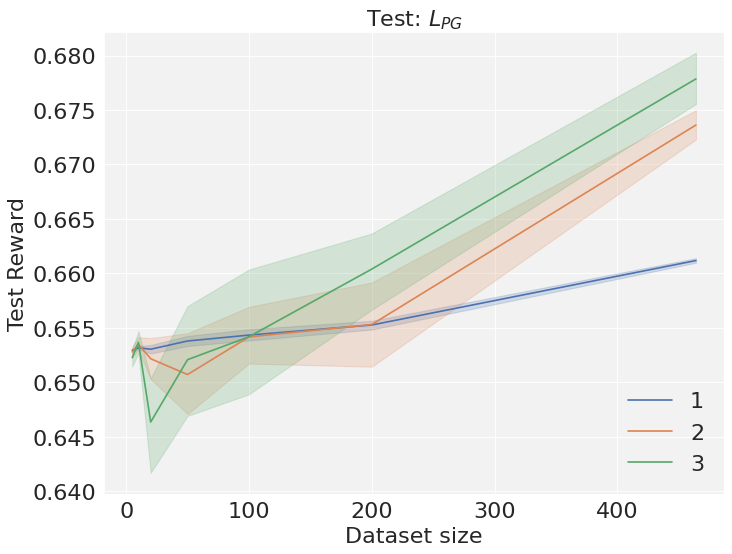

In [15]:
df_plot = copy.deepcopy(df)

# Conditions for the plot
table = llama_table
df_plot = df_plot[df_plot["model"] == "OpenAI"]
df_plot = df_plot[df_plot["k"] == 48]
df_plot = df_plot[df_plot["temp"] == 0.1]
df_plot = df_plot[df_plot["loss"] == "$L_{PG}$"]

print(len(df_plot))

# Set style
fs = 20
palette = sns.color_palette('deep', n_colors=df_plot['layer'].nunique())
sns.set_style("darkgrid", {"axes.facecolor": ".95"})
fig, ax =plt.subplots(figsize=(10, 7.5), dpi= 80, facecolor='w', edgecolor='k')
plt.rcParams['font.size'] = fs

# Plot
sns.lineplot(x="n_probs", y="test_rs", hue="layer", data=df_plot, errorbar=('ci', 95), ax=ax, palette=palette)
ax.set_title(f"Test: {df_plot['loss'].unique()[0]}", fontsize=fs)
ax.set_ylabel("Test Reward", fontsize=fs)
ax.set_xlabel("Dataset size", fontsize=fs)
ax.legend( loc='lower right', frameon=False) # bbox_to_anchor=(0., 0.25),
plt.show()

In [16]:
def get_skyline(path, k=10):
    samples = load_all_samples(path)
    return pass_at_k(samples, k)

skyline_list = []
for k in range(2, 50, 2):
    skyline_list.append(get_skyline(llama_paths["mbpp_test"], k))

In [17]:
df.columns

Index(['n_probs', 'seed', 'layer', 'val_rs', 'test_rs', 'he_rs', 'k', 'temp',
       'loss', 'model'],
      dtype='object')

In [18]:
temp = 0.1
data_size = 464

skyline_df = pd.DataFrame(
    {"k": list(range(2, 50, 2)),
     "test_rs": skyline_list, 
     "loss": "Skyline (Pass@k)", 
     "temp": [temp]*len(skyline_list), 
     "val_rs": [0]*len(skyline_list),
    "layer": [1]*len(skyline_list),
    "n_probs": [data_size]*len(skyline_list),
     "seed": [0]*len(skyline_list),
     "model": ["LLAMA"]*len(skyline_list),
    "he_rs": [0]*len(skyline_list),
     }
     )

744


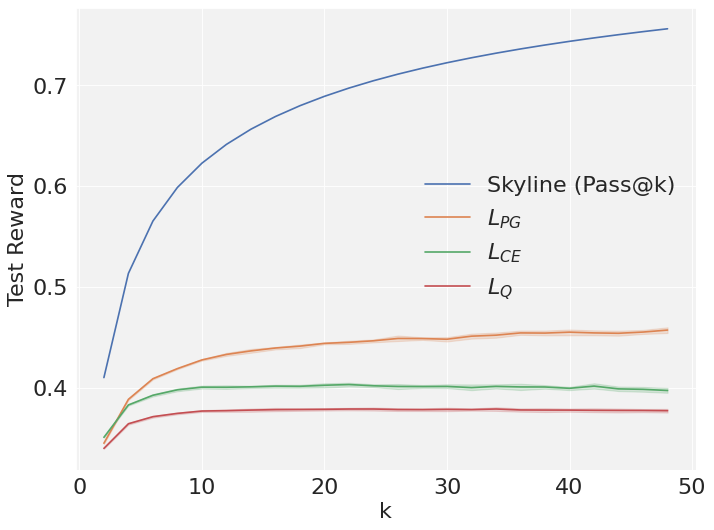

In [19]:
df_plot = copy.deepcopy(df)
df_plot = pd.concat([skyline_df, df_plot])

# Conditions for the plot
df_plot = df_plot[df_plot["model"] == "LLAMA"]
df_plot = df_plot[df_plot["temp"] == temp]
df_plot = df_plot[df_plot["n_probs"] == data_size]
df_plot = df_plot[df_plot["layer"] == 1]

print(len(df_plot))

# Set style
fs = 20
palette = sns.color_palette('deep', n_colors=df_plot['loss'].nunique())
sns.set_style("darkgrid", {"axes.facecolor": ".95"})
fig, ax =plt.subplots(figsize=(10, 7.5), dpi= 80, facecolor='w', edgecolor='k')
plt.rcParams['font.size'] = fs

# Plot
sns.lineplot(x="k", y="test_rs", hue="loss", data=df_plot, errorbar=('ci', 95), ax=ax, palette=palette)
# ax.set_title(f"{df_plot['model'].unique()[0]}", fontsize=fs)
ax.set_ylabel("Test Reward", fontsize=fs)
ax.set_xlabel("k", fontsize=fs)
ax.legend( loc='right', frameon=False,)#  bbox_to_anchor=(0., 0.25))
plt.show()

# Get values for table

In [23]:
df_plot = copy.deepcopy(df)

k = 48
temp = 0.1
layer = 1
data_size = 464

for model in df_plot["model"].unique():
    for loss in df_plot["loss"].unique():
        df_table = copy.deepcopy(df_plot)
        df_table = df_table[df_table["model"] == model]
        df_table = df_table[df_table["temp"] == temp]
        df_table = df_table[df_table["n_probs"] == data_size]
        df_table = df_table[df_table["layer"] == layer]
        df_table = df_table[df_table["loss"] == loss]
        df_table = df_table[df_table["k"] == k]
        print(model, loss, len(df_table))
        print("Test:", f"{df_table['test_rs'].mean():.4f}")
        print("Val:", f"{df_table['val_rs'].mean():.4f}")
        print("HE:", f"{df_table['he_rs'].mean():.4f}")
        print()



OpenAI $L_{PG}$ 10
Test: 0.6612
Val: 0.0000
HE: 0.5384

OpenAI $L_{CE}$ 10
Test: 0.6502
Val: 0.0000
HE: 0.5387

OpenAI $L_Q$ 10
Test: 0.6543
Val: 0.0000
HE: 0.5421

LLAMA $L_{PG}$ 10
Test: 0.4573
Val: 0.5570
HE: 0.3457

LLAMA $L_{CE}$ 10
Test: 0.3974
Val: 0.4820
HE: 0.3213

LLAMA $L_Q$ 10
Test: 0.3774
Val: 0.4501
HE: 0.2892



960


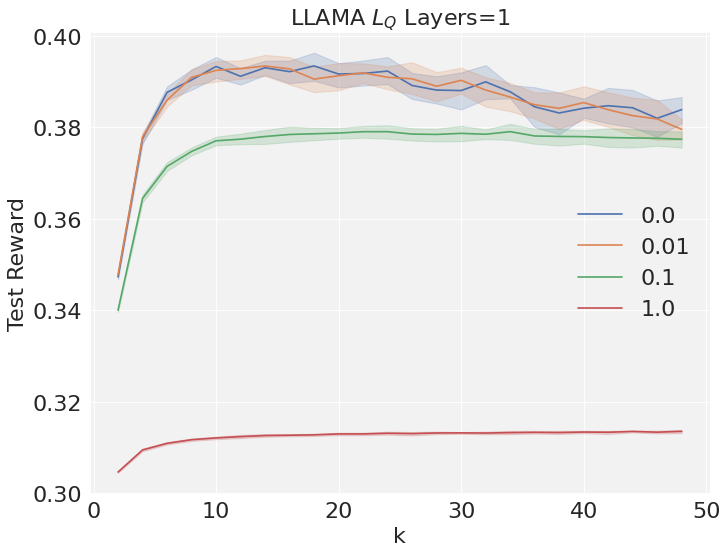

In [21]:
df_plot = copy.deepcopy(df)

# Conditions for the plot
table = llama_table
df_plot = df_plot[df_plot["model"] == "LLAMA"]
df_plot = df_plot[df_plot["loss"] == "$L_Q$"]
df_plot = df_plot[df_plot["n_probs"] == 464]
df_plot = df_plot[df_plot["layer"] == 1]

print(len(df_plot))

fs = 20
palette = sns.color_palette('deep', n_colors=df_plot['temp'].nunique())
sns.set_style("darkgrid", {"axes.facecolor": ".95"})
fig, ax =plt.subplots(figsize=(10, 7.5), dpi= 80, facecolor='w', edgecolor='k')
plt.rcParams['font.size'] = fs

# Plot
sns.lineplot(x="k", y="test_rs", hue="temp", data=df_plot, errorbar=('ci', 95), ax=ax, palette=palette)
ax.set_title(f"{df_plot['model'].unique()[0]} {df_plot['loss'].unique()[0]} Layers={df_plot['layer'].unique()[0]}", fontsize=fs)
ax.set_ylabel("Test Reward", fontsize=fs)
ax.set_xlabel("k", fontsize=fs)
ax.legend( loc='right', frameon=False,)#  bbox_to_anchor=(0., 0.25))
plt.show()